# Cluster analyses

This code splits the df into windows of a specified length. 
The result is a list with each cell containing time_length X channels. 
The raw data contains 200ms of a prewindow and 1000ms of the test window.

In [ ]:
import pandas as pd
import numpy as np
import setup_jwlab
from jwlab.constants import cleaned_data_filepath
from jwlab.cluster_analysis import prep_cluster_analysis
from jwlab.ml_prep import  average_trials_and_participants, average_trials
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from scipy import stats
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn import preprocessing
from scipy.stats import kurtosis, skew
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
length_per_window = 50 #just change this, do not alter the prep files
num_sliding_windows = int(1200/ length_per_window)

In [ ]:
# all 9m 
participants = ["904", "905", "906", "908", "910", "909", "912","913", "914", "916", "917", "919",\
                "920",  "923","921", "924", "927", "928", "929", "930", "932"]

In [ ]:
#subset 9m
# participants = ["904", "905", "906", "908", "909","910", "912", "913", "914",  "916", "917", "921", "923", "927", "929", "930", "932"] 

In [3]:
participants = ["106", "107", "109", "111", "112", "115", "116", "117", "119", "121", "122", "120", "124"]


In [ ]:
participants = ["106", "107", "109", "111", "112", "115", "116", "117", "119", "121", "122", "120", "124",\
               "904", "905", "906", "908", "909", "912","913", "914", "916", "917", "919",\
                "920", "921", "923", "924", "927", "928", "929", "930", "932"]


# Trial count code

In [ ]:
#get trial counts
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)


for i in participants:
    ps =[i]
    X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, ps, downsample_num=1000, averaging="no_averaging", length_per_window=length_per_window)
    y[0]
    np.amax(y[0])
    unique, counts = np.unique(y[0], return_counts=True)
    
    print(i)
    print(dict(zip(unique, counts)))

In [ ]:
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)



## Train raw test avg

In [ ]:
# build raw matrix
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="no_average_labels", length_per_window=length_per_window)
# Xc, yc, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)
#Xc is just for compairson in debugging


In [ ]:
print(len(X))
print(X[0].shape)
print(num_sliding_windows)

In [ ]:
# print(type(Xc))
# print(len(Xc))

In [ ]:
print(type(y))
print(type(y[0]))
print(len(y))

In [ ]:
# print(type(df_test))
# print(len(X))

In [ ]:
X[0]

In [ ]:
# set up for new df with labels and ps
num_participants = len(participants)
num_indices = len(X[0])
fivefold_testsize = int(.20*num_indices)
test_indices = np.random.choice(num_indices-1, fivefold_testsize, replace=False)

df_test = []
df_train = []

for i in range(num_sliding_windows):
    ## will need each window
    X[i] = X[i].reset_index()

    # #create new df with these indices and removing from orig
    df_test.append(X[i].iloc[test_indices])
    df_train.append(X[i].drop(X[i].index[test_indices]))
    assert(len(df_train[i]) + len(df_test[i]) == len(X[i]))
    df_test[i] = df_test[i].drop(columns=['index'], axis=1) 
    df_train[i] = df_train[i].drop(columns=['index'], axis=1)
    




In [ ]:
print(len(df_test))
print(df_test[0].shape)
print(len(df_train))
print(df_train[0].shape)

In [ ]:
df_test[0]

In [ ]:

# create training matrix:
X_train=[]
y_train=[]
for i in range(num_sliding_windows):
    y_train.append(df_train[i].label.values)
    X_train.append(df_train[i].drop(columns = ['label', 'participant'], axis = 1))





In [ ]:
# create test matrices
X_test = [] # test raw trials
y_test = [] 
X_test_t = [] # test avg trials
y_test_t = [] 
X_test_pt = [] # test avg trials and ps
y_test_pt = [] 

for i in range(num_sliding_windows):
    y_test.append(df_test[i].label.values)
    X_test.append(df_test[i].drop(columns = ['label', 'participant'], axis = 1))


    X_test_t_temp, y_test_temp, ps, w = average_trials(df_test[0])
    X_test_t.append(pd.DataFrame(X_test_t_temp))
    y_test_t.append(y_test_temp)
    
    X_test_pt_temp, y_test_temp_pt, ps, w = average_trials_and_participants(df_test[0], participants)
    X_test_pt.append(pd.DataFrame(X_test_pt_temp))
    y_test_pt.append(y_test_temp_pt)
    

In [ ]:
# change y's to binary:
for i in range(num_sliding_windows):
    y_train[i][y_train[i] < 8] = 0
    y_train[i][y_train[i] >= 8] = 1
    
    y_test[i][y_test[i] < 8] = 0
    y_test[i][y_test[i] >= 8] = 1
    
    y_test_t[i][y_test_t[i] < 8] = 0
    y_test_t[i][y_test_t[i] >= 8] = 1
    
    y_test_pt[i][y_test_pt[i] < 8] = 0
    y_test_pt[i][y_test_pt[i] >= 8] = 1
        
   



## Predict first letters

In [ ]:
for i in range(num_sliding_windows):
    y_train[i][y_train[i] < 5] = 0 # b
    y_train[i][y_train[i] == 9] = 0 # b
    y_train[i][y_train[i] == 10] = 0 # b
    y_train[i][y_train[i] == 5] = 1
    y_train[i][y_train[i] == 6] = 1
    y_train[i][y_train[i] == 7] = 1
    y_train[i][y_train[i] == 8] = 1
    y_train[i][y_train[i] > 10] = 1
    
    
    y_test[i][y_test[i] < 5] = 0 # b
    y_test[i][y_test[i] == 9] = 0 # b
    y_test[i][y_test[i] == 10] = 0 # b
    y_test[i][y_test[i] == 5] = 1
    y_test[i][y_test[i] == 6] = 1
    y_test[i][y_test[i] == 7] = 1
    y_test[i][y_test[i] == 8] = 1
    y_test[i][y_test[i] > 10] = 1
    
    
    y_test_t[i][y_test_t[i] < 5] = 0 # b
    y_test_t[i][y_test_t[i] == 9] = 0 # b
    y_test_t[i][y_test_t[i] == 10] = 0 # b
    y_test_t[i][y_test_t[i] == 5] = 1
    y_test_t[i][y_test_t[i] == 6] = 1
    y_test_t[i][y_test_t[i] == 7] = 1
    y_test_t[i][y_test_t[i] == 8] = 1
    y_test_t[i][y_test_t[i] > 10] = 1
    

    y_test_pt[i][y_test_pt[i] < 5] = 0 # b
    y_test_pt[i][y_test_pt[i] == 9] = 0 # b
    y_test_pt[i][y_test_pt[i] == 10] = 0 # b
    y_test_pt[i][y_test_pt[i] == 5] = 1
    y_test_pt[i][y_test_pt[i] == 6] = 1
    y_test_pt[i][y_test_pt[i] == 7] = 1
    y_test_pt[i][y_test_pt[i] == 8] = 1
    y_test_pt[i][y_test_pt[i] > 10] = 1
        
   

In [ ]:
type(y_train[0])

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

In [ ]:
X_train[0].shape

In [ ]:
X_test_pt[0].shape

In [9]:


model = LinearSVC(C=1e-9, max_iter=1000)
#model = SVC(gamma=.001, kernel = 'rbf', C = 100)

# from sklearn import preprocessing


results = {}



for j in range(num_sliding_windows):
        
        model.fit(X_train[j], y_train[j])
        
        # validation, predict raw
#         y_pred = model.predict(X_train[j])
#         testScore = accuracy_score(y_train[j],y_pred)
        
        # predict averaged across trials
#         y_pred = model.predict(X_test_t[j])
#         testScore = accuracy_score(y_test_t[j],y_pred)
        
        # predict averaged across trials and ps
        y_pred = model.predict(X_test_pt[j])
        testScore = accuracy_score(y_test_pt[j],y_pred)


        if j in results.keys(): 
            results[j].append(testScore)
        else:
            results[j]=[]
            results[j].append(testScore)
    


In [10]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))

print( np.mean(scoreMean))
print(scoreMean)
print(stdev)

0.16666666666666666
[0.3125, 0.4375, 0.1875, 0.0625, 0.0625, 0.125, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.125, 0.125, 0.125, 0.125, 0.125, 0.1875, 0.125, 0.125, 0.25, 0.25, 0.25, 0.3125, 0.375]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
# scoreMean = [0.5125, 0.5125, 0.4625, 0.575, 0.6625, 0.4875, 0.5875, 0.55, 0.475, 0.5125, 0.525, 0.5, 0.4875, 0.4375, 0.45, 0.5375, 0.475, 0.3375, 0.325, 0.45, 0.45, 0.4, 0.45, 0.475]


# stdev = [0.0306186217847898, 0.0306186217847898, 0.0701560760020114, 0.05, 0.042389562394533, 0.0364434493427832, 0.0423895623945329, 0.0537645329190164, 0.0507752400289747, 0.0723489806424389, 0.0728868986855662, 0.0625, 0.0459279326771846, 0.0592927061281571, 0.0537645329190164, 0.0423895623945329, 0.0728868986855662, 0.07806247497998, 0.0364434493427832, 0.0800390529679106, 0.0459279326771846, 0.0643476883811687, 0.0605959982177041, 0.0467707173346742]




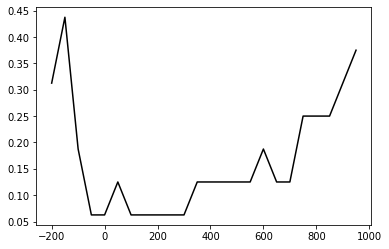

In [12]:
#plot results:

x_graph = np.arange(-200,1000,length_per_window)
y_graph = scoreMean
stdev = np.array(stdev)
error = stdev
plt.plot(x_graph, y_graph, 'k-')
plt.fill_between(x_graph, y_graph-error, y_graph+error)
plt.show()

## Cross validation
For raw data

In [ ]:
# Randomized order of cross val, for raw data matrix

X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)


num_iterations = 5
num_folds = 5

results = {}
for i in range(num_iterations):
    for j in range(num_sliding_windows):
        Xfirst = X[j]
        yfirst = y[j]
        Xfirst['label'] = yfirst
        Xfirst = Xfirst.sample(frac=1).reset_index(drop=True) #randomization
        ys = Xfirst['label']
        Xs = Xfirst.drop(columns=['label'])
        
        #model = SVC(gamma=.001, kernel = 'rbf', C=1)
        model = LinearSVC(C=1, max_iter=5000)
        cv_results = cross_validate(model, Xs, ys, cv=num_folds)
        if j in results.keys(): 
            results[j] += cv_results['test_score'].tolist()
        else:
            results[j] = cv_results['test_score'].tolist()
    print(i)

    
for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds


In [ ]:
X[0].shape
X.shape

## Cross validation
For averaged data

In [ ]:
# Cross validation with RepeatedKFold for averaged matrices

#Xwin, ywin, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials", length_per_window=length_per_window)
#Xwin, ywin, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials_and_participants", length_per_window=length_per_window)


num_iterations = 3
num_folds = 5


import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score



results = {}
for j in range(num_sliding_windows):
    X = Xwin[j]
    y = ywin[j]

    #model = SVC(gamma=.001, kernel = 'rbf', C=1e-4)
    model = LinearSVC(C=1, max_iter=5000)
    rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_iterations, random_state=2652124)
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        testScore = accuracy_score(y_test,y_pred)

        if j in results.keys(): 
            results[j].append(testScore)
        else:
            results[j]=[]
            results[j].append(testScore)
    

for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds

In [ ]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))

print( np.mean(scoreMean))
print(scoreMean)
print(stdev)

In [ ]:
# T-test
accuracy_by_guessing = [0.5] * (num_iterations * num_folds)
pvalues = []
for i in range(num_sliding_windows):
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

In [ ]:
# Finding contiguous time cluster
valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print(valid_window)

# Feature Extraction

In [ ]:
# X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1200, averaging="no_averaging", length_per_window=length_per_window)



In [ ]:
#X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials", length_per_window=length_per_window)
X, y, good_trial_count = prep_cluster_analysis(cleaned_data_filepath, participants, downsample_num=1000, averaging="average_trials_and_participants", length_per_window=length_per_window)



for k in range(len(X)):
    X[k] = pd.DataFrame(data=X[k][0:,0:])

In [ ]:
#Normalization 


#funcs = [np.mean, np.min, np.max, np.var, skew, kurtosis]
funcs = [np.mean, np.min, np.max, np.var]

df_feats_list = []

for j in range(num_sliding_windows):  
    df_feats = X[j].apply(funcs, axis=1)
    
    # calc skew
    skew_j = skew(X[j], axis = 1)
    df_feats['skew'] = skew_j

    # calc kurtosis
    kurt_j = kurtosis(X[j], axis = 1)
    df_feats['kurtosis'] = kurt_j


    
    #normalize: (x-xmin)/(max-min)

    # Get column names first
    names = df_feats.columns

    normalized_df = []
    for i in names: 
        x_array = np.array(df_feats[i])
        normalized_X = preprocessing.normalize([x_array])
        normalized_df.append(normalized_X)
    
    
    df_1 = pd.DataFrame(np.concatenate(normalized_df))
    df = df_1.T #transpose
    df.columns= ['mean', 'amin', 'amax', 'var', 'skew', 'kurtosis']

    

    #put all windows together into a list
    df_feats_list.append(df)
    
    




In [ ]:
# # Standarization: 

# #funcs = [np.mean, np.min, np.max, np.var, skew, kurtosis]
# funcs = [np.mean, np.min, np.max, np.var]

# df_feats_list = []

# for j in range(num_sliding_windows):  
#     df_feats = X[j].apply(funcs, axis=1)
    
#     # calc skew
#     skew_j = skew(X[j], axis = 1)
#     df_feats['skew'] = skew_j

#     # calc kurtosis
#     kurt_j = kurtosis(X[j], axis = 1)
#     df_feats['kurtosis'] = kurt_j


#     #standarized: (x-mean)/(stdev)

#      # Get column names first
#     names = df_feats.columns

#     # Create the Scaler object
#     scaler = preprocessing.StandardScaler()
#     # Fit your data on the scaler object
#     scaled_df = scaler.fit_transform(df_feats)
#     scaled_df = pd.DataFrame(scaled_df, columns=names)

#     #put all windows together into a list
#     df_feats_list.append(scaled_df)



# Cross val on extracted features

In [ ]:

num_iterations = 5
num_folds = 5

results = {}
for i in range(num_iterations):
    for j in range(num_sliding_windows):
        Xfirst = df_feats_list[j]
        yfirst = y[j]
        Xfirst['label'] = yfirst
        Xfirst = Xfirst.sample(frac=1).reset_index(drop=True) #randomization
        ys = Xfirst['label']
        Xs = Xfirst.drop(columns=['label'])
        
        #model = SVC(gamma=.001, kernel = 'rbf', C=100)
        model = LinearSVC(C=1e-3, max_iter=1000)
        cv_results = cross_validate(model, Xs, ys, cv=num_folds)
        if j in results.keys(): 
            results[j] += cv_results['test_score'].tolist()
        else:
            results[j] = cv_results['test_score'].tolist()
    print(i)

    
for i in range(num_sliding_windows):
    assert len(results[i]) == num_iterations * num_folds

In [ ]:
scoreMean = []
stdev = []

for i in range(num_sliding_windows):
    scoreMean.append(np.mean(results[i]))
    stdev.append(np.std(results[i]))



In [ ]:
scoreMean

In [ ]:
max(scoreMean)

In [ ]:
stdev

In [ ]:
# T-test
accuracy_by_guessing = [0.5] * (num_iterations * num_folds)
pvalues = []
for i in range(num_sliding_windows):
    istat = stats.ttest_1samp(results[i], .5)
    pvalues += [istat.pvalue] if istat.statistic > 0 else [1]

In [ ]:
# Finding contiguous time cluster
valid_window = [i for i,v in enumerate(pvalues) if v <= 0.025]
print(valid_window)

In [ ]:
#plot results:

x_graph = np.arange(-200,1000,length_per_window)
y_graph = scoreMean
stdev = np.array(stdev)
error = stdev
plt.plot(x_graph, y_graph, 'k-')
plt.fill_between(x_graph, y_graph-error, y_graph+error)
plt.show()